# Maskinlæring

* Maskinlæring er i grunn bare komplisert statistikk/regresjon:
  * Vi tilpasser en modell så godt vi kan basert på tilgjengelig data
  * Modellen kan være en linje (lineær regresjon), eller valgtrær, support vector machines, nevrale netverk osv

## Eksempel med lineær regresjon

In [22]:
import json
import requests
from pyjstat import pyjstat
def hent_dataset(filnavn):
    with open(filnavn, 'r') as file:
        ssbAPIdata = json.load(file)

    postUrl = ssbAPIdata["postUrl"]
    tabellnummer = ssbAPIdata["tableIdForQuery"]
    query = ssbAPIdata["queryObj"]
    print(f"Henter data fra tabell {tabellnummer}")
    response = requests.post(postUrl, json=query)

    if response.status_code == 200:
        print("Data hentet: OK")
    else:
        print(f"""Data kunne ikke hentes, feilkode {response.status_code}
        Responstekst: response.text""")
        return None

    dataset = pyjstat.Dataset.read(response.text)
    df = dataset.write("dataframe")
    df_id = dataset.write("dataframe", naming="id")

    print(f"""Hentet dataset: {dataset['label']}""")
    return df, df_id, dataset

df, df_id, ds = hent_dataset("innenlandslanegjeld.json")
df_copy=df.copy()
df

Henter data fra tabell 06718
Data hentet: OK
Hentet dataset: 06718: Innenlandsk lånegjeld (mill. kr), etter låntakersektor, statistikkvariabel og måned


,låntakersektor,statistikkvariabel,måned,value
0,Husholdninger mv.,Innenlandsk lånegjeld,1987M12,448169
1,Husholdninger mv.,Innenlandsk lånegjeld,1988M01,450011
2,Husholdninger mv.,Innenlandsk lånegjeld,1988M02,453912
3,Husholdninger mv.,Innenlandsk lånegjeld,1988M03,456762
4,Husholdninger mv.,Innenlandsk lånegjeld,1988M04,458451
...,...,...,...,...
437,Husholdninger mv.,Innenlandsk lånegjeld,2024M05,4344594
438,Husholdninger mv.,Innenlandsk lånegjeld,2024M06,4363713
439,Husholdninger mv.,Innenlandsk lånegjeld,2024M07,4373839
440,Husholdninger mv.,Innenlandsk lånegjeld,2024M08,4394729


,Innenlandsk lånegjeld
måned,
1987-12-01,448169
1988-01-01,450011
1988-02-01,453912
1988-03-01,456762
1988-04-01,458451
...,...
2024-05-01,4344594
2024-06-01,4363713
2024-07-01,4373839


<Axes: xlabel='måned'>

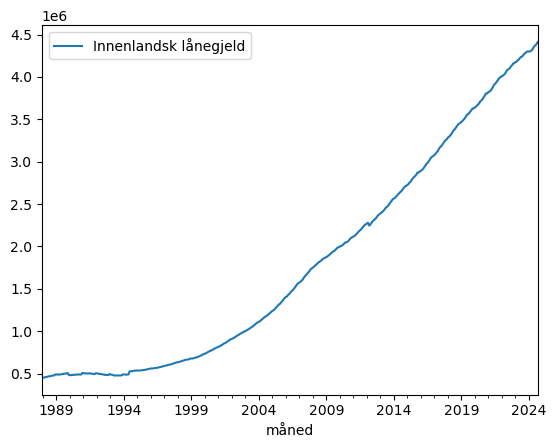

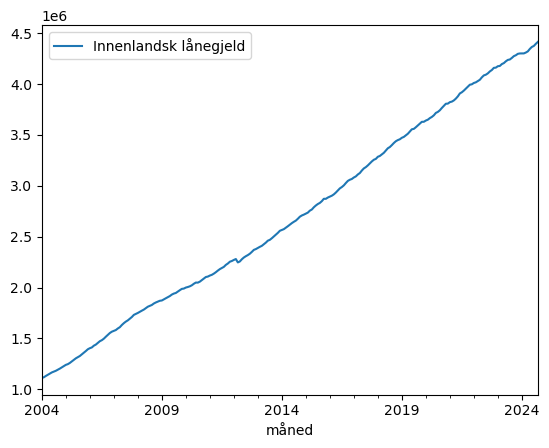

In [43]:
df = df_copy.copy()
df = df.drop(columns=["låntakersektor", "statistikkvariabel"])
df["måned"] = pd.to_datetime(df["måned"], format="%YM%m")
df = df.rename(columns={"value": "Innenlandsk lånegjeld"})
df=df.set_index("måned")
display(df)
df.plot()
##
df_linje = df.loc["2004":]
df_linje.plot()

0.9963861303658758

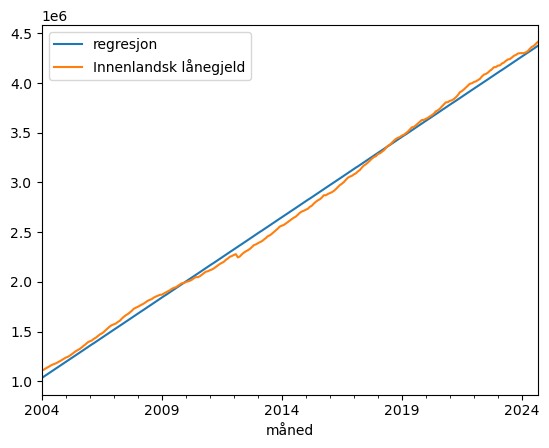

In [70]:
from sklearn.linear_model import LinearRegression

data = df_linje.reset_index()
data["dager"] = data["måned"] - data.loc[0,"måned"] #Ny kolonner med dager siden "start"
data["dager"] = data["dager"].dt.days # Fikser slik at dagene er flyttall

X = data[["dager"]] #Velger uavhengige variabler (dager siden start)
y = data["Innenlandsk lånegjeld"] #Velger avhengig variabel (mål)

modell = LinearRegression() # Lager en lineær regresjonsmodell
resultat = modell.fit(X,y) #Tilpasser modell til data (læring)
data["regresjon"] = modell.predict(X) # Bruker modell til å anslå avhengig variabel
ax = data.plot(x="måned", y="regresjon")
data.plot(x="måned", y="Innenlandsk lånegjeld", ax=ax)

Rsquared = modell.score(X,y) #Score med hvor godt linjen "passer"

## Typer læring
* I hovedtrekk ofte to typer:
  * «Supervised learning»: Algoritmen eller modellen lærer fra input/output data (vi vet hva "resultatet" skal være)
  * «Unsupervised learning»: Algoritmen eller modellen finner mønstre i data vi ikke "kjenner" i utgangspunktet

## Hovedmål
* Målet med «læringen» er at den opplærte modellen vår skal «funke» på data vi ikke har sett før
* Dersom den gjør det sier vi at modellen generaliserer bra

Vi må da typisk unngå:
* «Overfitting»: Modellen memoriserer kun testdataen vår
* «Underfitting»: Modellen har ikke lært nok

![https://miro.medium.com/v2/resize:fit:720/format:webp/1*lARssDbZVTvk4S-Dk1g-eA.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*lARssDbZVTvk4S-Dk1g-eA.png)

# Testdata og treningsdata
* For å anslå om modellen vår er god, eller om vi overtilpasser den, holder vi gjerne tilbake forskjellige subset av dataene våres:
  * Vi kan feks trekkke ut tilfeldige 20% som ikke brukes til trening av modellen, men til å teste modellen etterpå
* Ellers justerer man på parametre i modellen, forenkler data, straffer kompleksitet og mange andre "triks" for å lage gode modeller

![https://www.researchgate.net/publication/357570421/figure/fig2/AS:11431281210648059@1702062985384/Training-and-validation-scheme-for-machine-learning-methods-The-database-is-split-and.tif](https://www.researchgate.net/publication/357570421/figure/fig2/AS:11431281210648059@1702062985384/Training-and-validation-scheme-for-machine-learning-methods-The-database-is-split-and.tif)

![https://i0.wp.com/thaddeus-segura.com/wp-content/uploads/2021/06/Screen-Shot-2021-06-17-at-7.03.33-PM-1.png?resize=532%2C658&ssl=1](https://i0.wp.com/thaddeus-segura.com/wp-content/uploads/2021/06/Screen-Shot-2021-06-17-at-7.03.33-PM-1.png?resize=532%2C658&ssl=1)

# Noen eksempler fra sklearn
* Klynger
* Support vector machines

In [72]:
import sklearn.cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


menn_bmi = 26.9
kvinner_bmi = 25.2

menn_h = 180.4
kvinner_h = 167.2

mm = menn_bmi*(menn_h/100)**2
mk = kvinner_bmi*(kvinner_h/100)**2

n = 1000

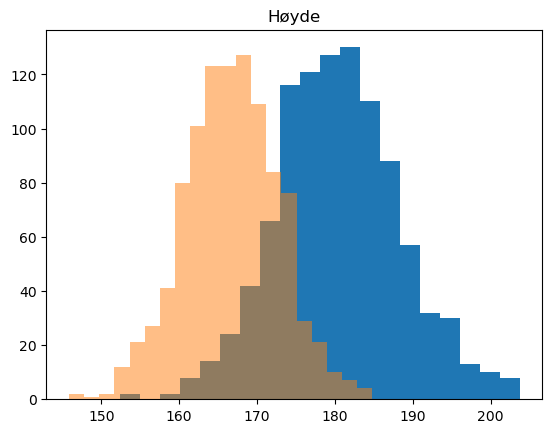

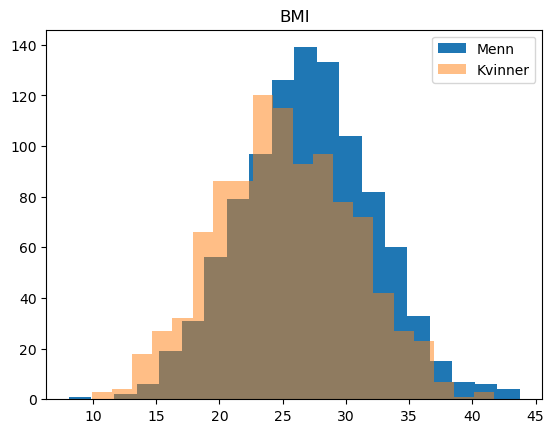

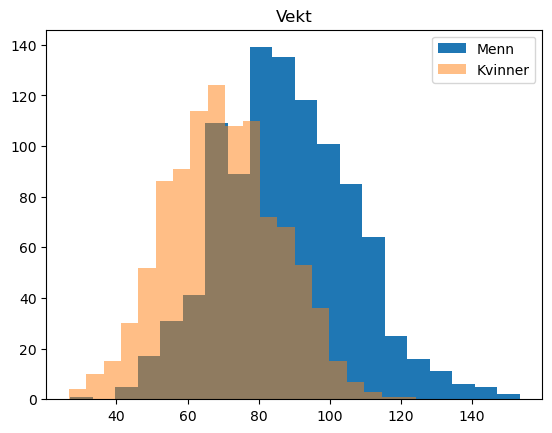

In [73]:
menn_bmi_liste = np.random.normal(loc=menn_bmi, scale=menn_bmi*0.2, size=n)
menn_hoyde_liste = np.random.normal(loc=menn_h, scale=8, size=1000)

kvinner_bmi_liste = np.random.normal(loc=kvinner_bmi, scale=menn_bmi*0.2, size=n)
kvinner_hoyde_liste = np.random.normal(loc=kvinner_h, scale=6, size=n)

menn_masse_liste = [ bmi*(h/100)**2 for bmi, h in zip(menn_bmi_liste, menn_hoyde_liste)]
kvinner_masse_liste = [ bmi*(h/100)**2 for bmi, h in zip(kvinner_bmi_liste, kvinner_hoyde_liste)]

plt.hist(menn_hoyde_liste, bins=20, label="Menn")
plt.hist(kvinner_hoyde_liste, bins=20, alpha=0.5, label="Kvinner")
plt.title("Høyde")
plt.show()


plt.hist(menn_bmi_liste, bins=20, label="Menn")
plt.hist(kvinner_bmi_liste, bins=20, alpha=0.5, label="Kvinner")
plt.legend()
plt.title("BMI")
plt.show()

plt.hist(menn_masse_liste, bins=20, label="Menn")
plt.hist(kvinner_masse_liste, bins=20, alpha=0.5, label="Kvinner")
plt.legend()
plt.title("Vekt")
plt.show()




,hoyde,vekt,Kjønn
1121,167.226954,101.884799,Kvinne
365,191.373013,68.968387,Mann
1545,163.467760,49.643423,Kvinne
8,179.099568,95.458492,Mann
321,184.198989,105.220967,Mann
...,...,...,...
829,165.897970,92.242556,Mann
178,187.914755,118.355489,Mann
1047,174.118426,61.442764,Kvinne
171,185.006923,72.520056,Mann


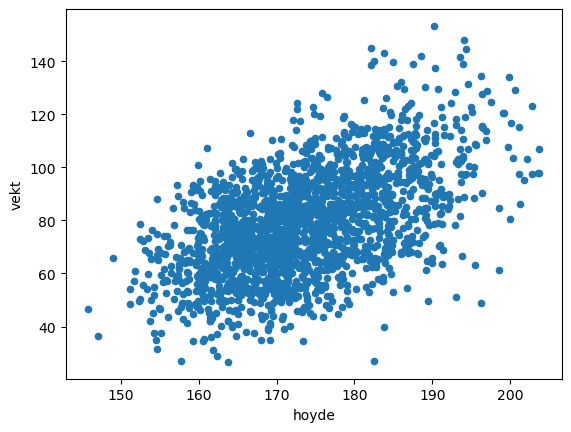

In [74]:
data={"hoyde": np.concatenate((menn_hoyde_liste, kvinner_hoyde_liste)), 
      "vekt":  np.concatenate((menn_masse_liste, kvinner_masse_liste)),
      "Kjønn": ["Mann"]*n+["Kvinne"]*n}


df = pd.DataFrame(data)
df.plot.scatter(x="hoyde", y="vekt")
df =df.reindex(np.random.permutation(df.index))
df

# KMeans clustering
* «Unsupervised learning»
* Vi prøver å dele data inn i klynger uten å nødvendigvis vite hva de representerer
* Noen ganger vet vi hvor mange klynger det burde være, andre ganger må vi prøve oss frem

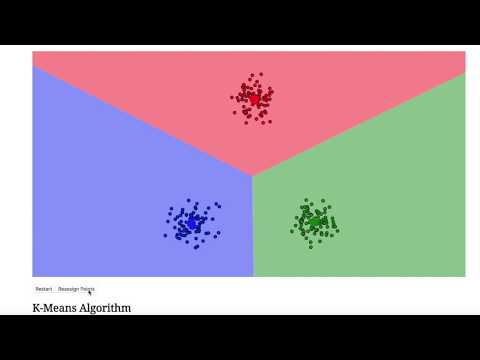

In [80]:
from IPython.display import YouTubeVideo
#Lenke: https://www.naftaliharris.com/blog/visualizing-k-means-clustering/
YouTubeVideo('R2e3Ls9H_fc', width=800, height=300)

In [75]:
from sklearn.cluster import KMeans



,hoyde,vekt,Kjønn,cluster
1121,167.226954,101.884799,Kvinne,1
365,191.373013,68.968387,Mann,0
1545,163.467760,49.643423,Kvinne,0
8,179.099568,95.458492,Mann,1
321,184.198989,105.220967,Mann,1
...,...,...,...,...
829,165.897970,92.242556,Mann,1
178,187.914755,118.355489,Mann,1
1047,174.118426,61.442764,Kvinne,0
171,185.006923,72.520056,Mann,0


In [1]:
import seaborn as sns


# K-nearest neighbors
* «Supervised learning» - Vi har data hvor vi kjenner klassifiseringene
* For nye usette datapunkt undersøker vi de $k$ nærmeste naboene til datapunktet, og klassifiseringen deres
* Klassifiseringen til det nye datapunktet bestemmes av disse

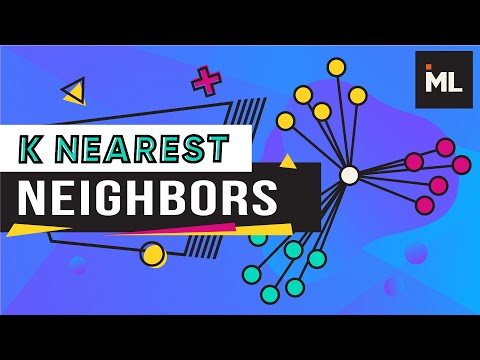

In [81]:
YouTubeVideo('0p0o5cmgLdE', width=800, height=300)

In [77]:
from sklearn.neighbors import KNeighborsClassifier




In [2]:
from sklearn.model_selection import train_test_split



# Akadmeisk sukksess
[Dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

In [83]:
df = pd.read_csv("stud_dropout.csv")
df["Target"].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

# Support vector machine
«supervised learning»

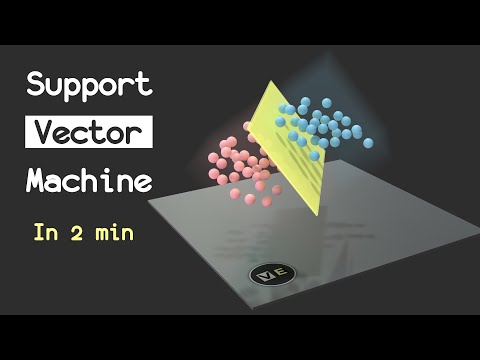

In [84]:
YouTubeVideo('_YPScrckx28', width=800, height=300)

In [87]:
from sklearn import svm
